In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**(a)**

In [4]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

100%|██████████| 170498071/170498071 [00:04<00:00, 39365128.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**(b)**

In [ ]:
losses = []
lrs = []
Tmax = 150
lr = 1e-5
model = allcnn_t().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    lr = 1.1*(lr)
    lrs.append(lr)
    for g in optimizer.param_groups:
      g['lr'] = lr
    optimizer.step()
    loss = loss.item()
    print('iteration', i, ":", loss)
    losses.append(loss)
    if i == Tmax:
      break

Num parameters:  1667166
iteration 0 : 2.299715280532837
iteration 1 : 2.28652286529541
iteration 2 : 2.291839838027954
iteration 3 : 2.2851712703704834
iteration 4 : 2.3121867179870605
iteration 5 : 2.312959909439087
iteration 6 : 2.323392391204834
iteration 7 : 2.298068046569824
iteration 8 : 2.321108341217041
iteration 9 : 2.3104138374328613
iteration 10 : 2.295553684234619
iteration 11 : 2.302586793899536
iteration 12 : 2.306321144104004
iteration 13 : 2.2993268966674805
iteration 14 : 2.286311388015747
iteration 15 : 2.3034555912017822
iteration 16 : 2.3019587993621826
iteration 17 : 2.299755573272705
iteration 18 : 2.3059914112091064
iteration 19 : 2.2825496196746826
iteration 20 : 2.2772412300109863
iteration 21 : 2.2973129749298096
iteration 22 : 2.296382427215576
iteration 23 : 2.319864511489868
iteration 24 : 2.283233642578125
iteration 25 : 2.2904508113861084
iteration 26 : 2.279034376144409
iteration 27 : 2.292517900466919
iteration 28 : 2.3032753467559814
iteration 29 : 2.

Text(0.5, 0, 'Learning Rate [log-scale]')

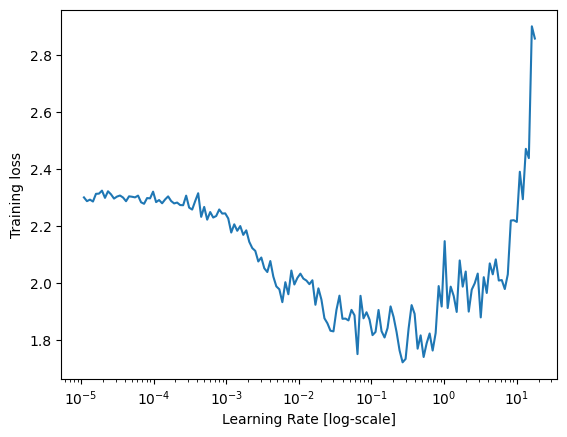

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lrs,losses)
plt.xscale('log')
plt.ylabel('Training loss')
plt.xlabel('Learning Rate [log-scale]')

In [ ]:
import numpy as np
lr_star = np.array(lrs)[np.array(losses) == min(np.array(losses))][0]
lr_star

0.268545149150829

**(c)**

In [7]:
def lr_set(t, t_0, t_max, lr_max):
  if t <= t_0:
    return 1e-4 + t/t_0 * lr_max
  else:
    return lr_max * np.cos(np.pi/2 * (t-t_0)/(t_max - t_0)) + 1e-6

In [ ]:
lrs = []
T_max = 391*100
T_0 = T_max/5
lr_max = lr_star / 10
t = 0
model = allcnn_t().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_max, momentum=0.9, weight_decay=0.001)

train_loss_values = []
train_error = []
val_loss_values = []
val_error = []
for epoch in range(100):
    correct = 0
    total = 0
    flag = 0
    running_loss = []
    running_accuracy = []
    model.train()
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to configured device
        lr = lr_set(t, T_0, T_max, lr_max)
        for g in optimizer.param_groups:
          g['lr'] = lr
        lrs.append(lr)
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        optimizer.step()
        train_loss_values.append(loss.item())
        train_error.append(100-100*correct/total)
        t = t + 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_accuracy.append(100 * correct / total)
    val_error.append(100-np.mean(running_accuracy))
    val_loss_values.append(np.mean(running_loss))
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, 100, np.mean(running_loss)))
    print('Accuracy of the network on the test images: {:.4f} %'.format(np.mean(running_accuracy)))

Num parameters:  1667166
Epoch [1/100], Validation Loss: 1.9685
Accuracy of the network on the test images: 28.0542 %
Epoch [2/100], Validation Loss: 1.7659
Accuracy of the network on the test images: 38.0177 %
Epoch [3/100], Validation Loss: 1.4635
Accuracy of the network on the test images: 49.3572 %
Epoch [4/100], Validation Loss: 1.2541
Accuracy of the network on the test images: 57.1426 %
Epoch [5/100], Validation Loss: 1.1974
Accuracy of the network on the test images: 57.9309 %
Epoch [6/100], Validation Loss: 0.9977
Accuracy of the network on the test images: 66.4610 %
Epoch [7/100], Validation Loss: 0.8894
Accuracy of the network on the test images: 69.8685 %
Epoch [8/100], Validation Loss: 0.9704
Accuracy of the network on the test images: 67.4399 %
Epoch [9/100], Validation Loss: 0.8737
Accuracy of the network on the test images: 70.3686 %
Epoch [10/100], Validation Loss: 0.7958
Accuracy of the network on the test images: 73.1435 %
Epoch [11/100], Validation Loss: 0.7958
Accu

Num parameters:  1667166


Text(0.5, 0, 'Weight Updates')

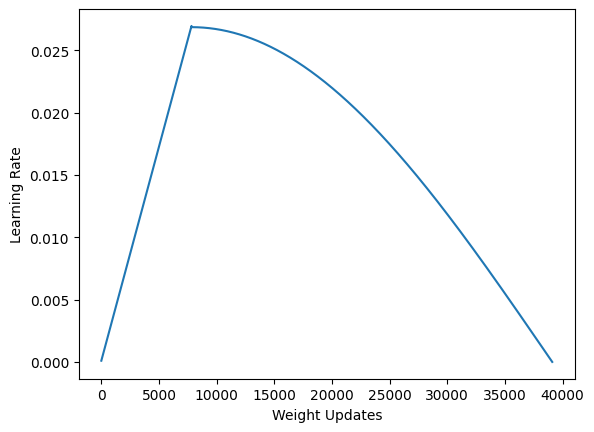

In [10]:
plt.plot(lrs)
plt.ylabel('Learning Rate')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Weight Updates')

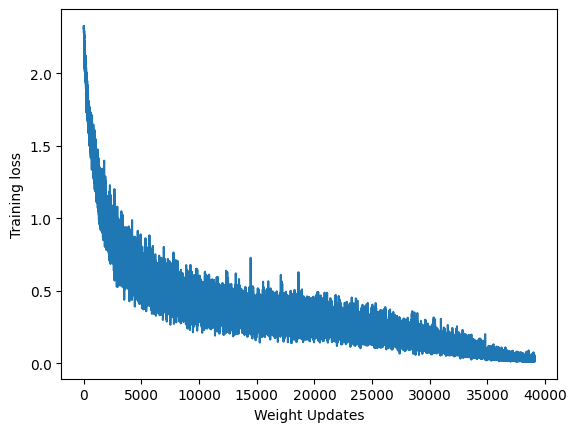

In [ ]:
plt.plot(train_loss_values)
plt.ylabel('Training loss')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Epoch')

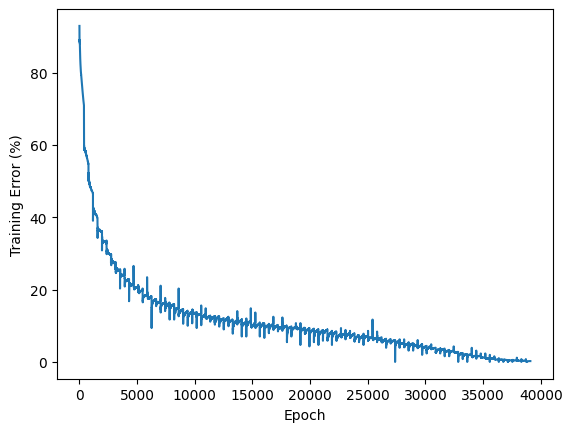

In [ ]:
plt.plot(train_error)
plt.ylabel('Training Error (%)')
plt.xlabel('Epoch')

Text(0.5, 0, 'Weight Updates')

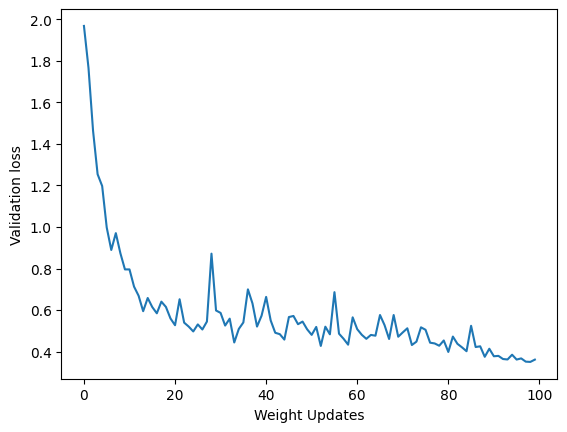

In [ ]:
plt.plot(val_loss_values)
plt.ylabel('Validation loss')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Epoch')

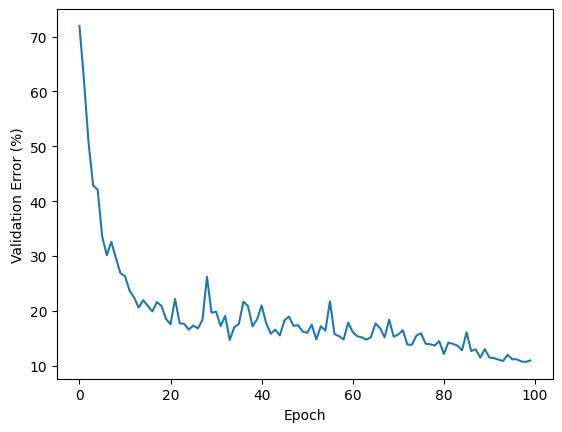

In [ ]:
plt.plot(val_error)
plt.ylabel('Validation Error (%)')
plt.xlabel('Epoch')

**(d)**

In [ ]:
lrs = []
T_max = 391*100
T_0 = T_max/5
lr_max = (lr_star / 10) * 5
t = 0
model = allcnn_t().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_max, momentum=0.5, weight_decay=0.001)

train_loss_values = []
train_error = []
val_loss_values = []
val_error = []
for epoch in range(100):
    correct = 0
    total = 0
    flag = 0
    running_loss = []
    running_accuracy = []
    model.train()
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to configured device
        lr = lr_set(t, T_0, T_max, lr_max)
        for g in optimizer.param_groups:
          g['lr'] = lr
        lrs.append(lr)
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        optimizer.step()
        train_loss_values.append(loss.item())
        train_error.append(100-100*correct/total)
        t = t + 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_accuracy.append(100 * correct / total)
    val_error.append(100-np.mean(running_accuracy))
    val_loss_values.append(np.mean(running_loss))
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, 100, np.mean(running_loss)))
    print('Accuracy of the network on the test images: {:.4f} %'.format(np.mean(running_accuracy)))

Num parameters:  1667166
Epoch [1/100], Validation Loss: 2.2236
Accuracy of the network on the test images: 23.9413 %
Epoch [2/100], Validation Loss: 1.8743
Accuracy of the network on the test images: 35.0696 %
Epoch [3/100], Validation Loss: 1.5254
Accuracy of the network on the test images: 46.6879 %
Epoch [4/100], Validation Loss: 1.3054
Accuracy of the network on the test images: 54.1732 %
Epoch [5/100], Validation Loss: 1.3384
Accuracy of the network on the test images: 55.1640 %
Epoch [6/100], Validation Loss: 0.9636
Accuracy of the network on the test images: 66.6973 %
Epoch [7/100], Validation Loss: 0.9559
Accuracy of the network on the test images: 67.3506 %
Epoch [8/100], Validation Loss: 0.9456
Accuracy of the network on the test images: 68.1730 %
Epoch [9/100], Validation Loss: 0.8550
Accuracy of the network on the test images: 69.9985 %
Epoch [10/100], Validation Loss: 0.8813
Accuracy of the network on the test images: 71.2320 %
Epoch [11/100], Validation Loss: 0.7564
Accu

Text(0.5, 0, 'Weight Updates')

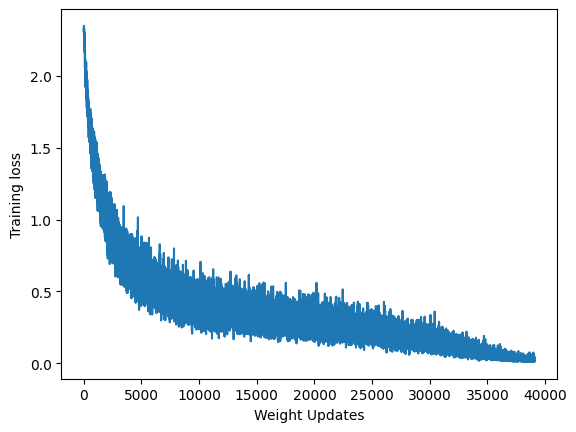

In [ ]:
plt.plot(train_loss_values)
plt.ylabel('Training loss')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Epoch')

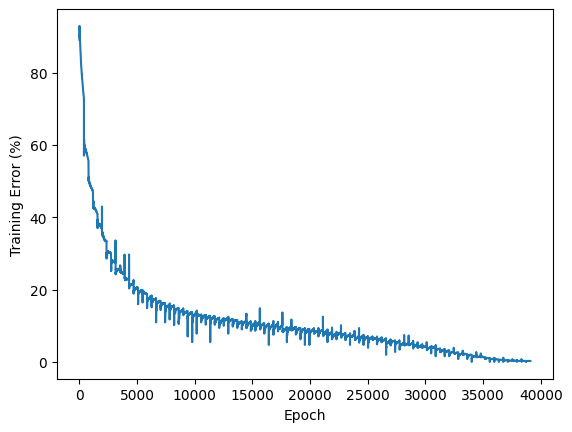

In [ ]:
plt.plot(train_error)
plt.ylabel('Training Error (%)')
plt.xlabel('Epoch')

Text(0.5, 0, 'Weight Updates')

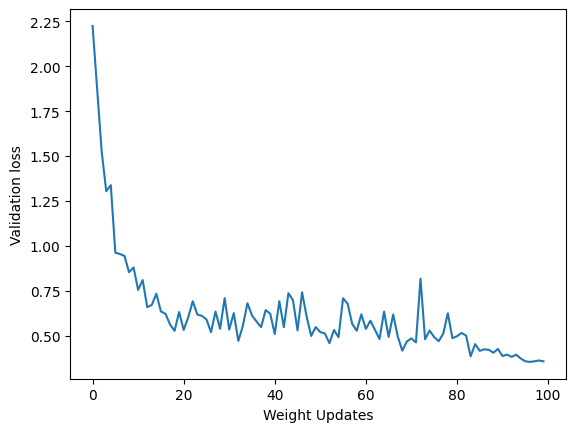

In [ ]:
plt.plot(val_loss_values)
plt.ylabel('Validation loss')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Epoch')

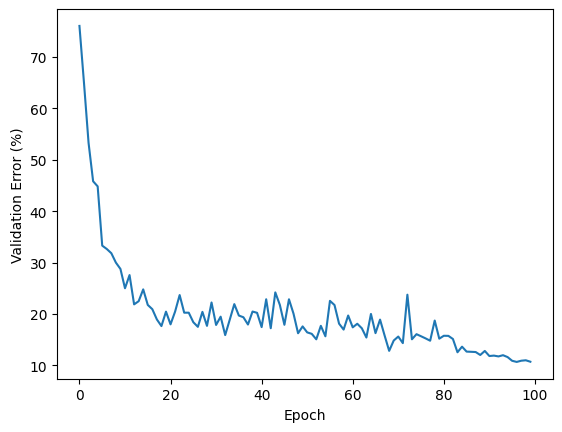

In [ ]:
plt.plot(val_error)
plt.ylabel('Validation Error (%)')
plt.xlabel('Epoch')

In [ ]:
lrs = []
T_max = 391*100
T_0 = T_max/5
lr_max = lr_star / 10
t = 0
model = allcnn_t().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_max, momentum=0.5, weight_decay=0.001)

train_loss_values = []
train_error = []
val_loss_values = []
val_error = []
for epoch in range(100):
    correct = 0
    total = 0
    flag = 0
    running_loss = []
    running_accuracy = []
    model.train()
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to configured device
        lr = lr_set(t, T_0, T_max, lr_max)
        for g in optimizer.param_groups:
          g['lr'] = lr
        lrs.append(lr)
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        optimizer.step()
        train_loss_values.append(loss.item())
        train_error.append(100-100*correct/total)
        t = t + 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_accuracy.append(100 * correct / total)
    val_error.append(100-np.mean(running_accuracy))
    val_loss_values.append(np.mean(running_loss))
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, 100, np.mean(running_loss)))
    print('Accuracy of the network on the test images: {:.4f} %'.format(np.mean(running_accuracy)))

Num parameters:  1667166
Epoch [1/100], Validation Loss: 2.2974
Accuracy of the network on the test images: 19.8026 %
Epoch [2/100], Validation Loss: 2.0755
Accuracy of the network on the test images: 26.4519 %
Epoch [3/100], Validation Loss: 1.9458
Accuracy of the network on the test images: 32.1427 %
Epoch [4/100], Validation Loss: 1.7922
Accuracy of the network on the test images: 36.8807 %
Epoch [5/100], Validation Loss: 1.6746
Accuracy of the network on the test images: 41.8774 %
Epoch [6/100], Validation Loss: 1.5166
Accuracy of the network on the test images: 46.4780 %
Epoch [7/100], Validation Loss: 1.4559
Accuracy of the network on the test images: 48.9597 %
Epoch [8/100], Validation Loss: 1.1612
Accuracy of the network on the test images: 59.3672 %
Epoch [9/100], Validation Loss: 1.1698
Accuracy of the network on the test images: 59.6997 %
Epoch [10/100], Validation Loss: 1.0803
Accuracy of the network on the test images: 63.3087 %
Epoch [11/100], Validation Loss: 0.9465
Accu

Text(0.5, 0, 'Weight Updates')

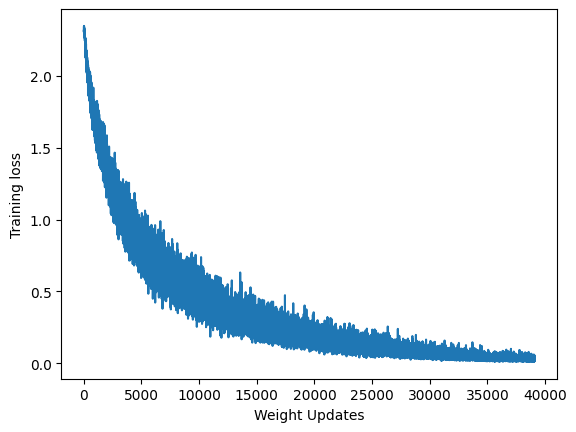

In [ ]:
plt.plot(train_loss_values)
plt.ylabel('Training loss')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Epoch')

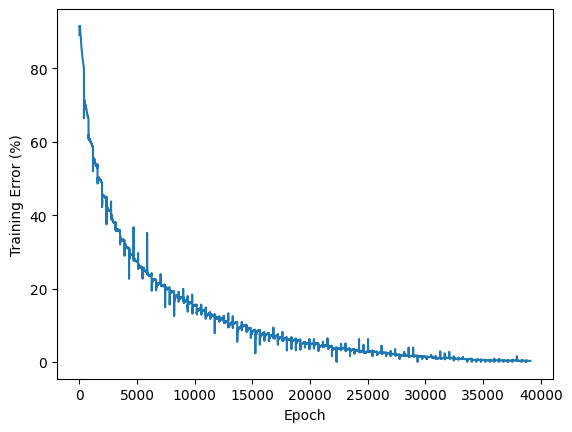

In [ ]:
plt.plot(train_error)
plt.ylabel('Training Error (%)')
plt.xlabel('Epoch')

Text(0.5, 0, 'Weight Updates')

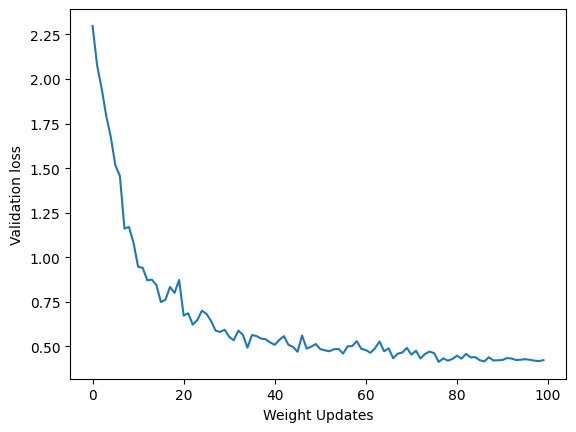

In [ ]:
plt.plot(val_loss_values)
plt.ylabel('Validation loss')
plt.xlabel('Weight Updates')

Text(0.5, 0, 'Epoch')

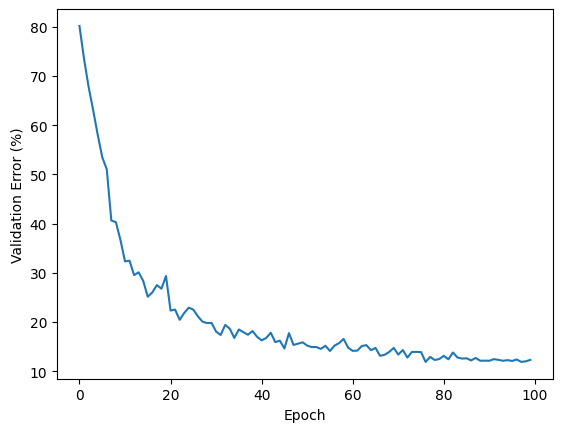

In [ ]:
plt.plot(val_error)
plt.ylabel('Validation Error (%)')
plt.xlabel('Epoch')